In [1]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

import matplotlib.pyplot as plt




In [42]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    u=np.linspace(ui,uf,1000)
    u_backward=np.linspace(uf,ui,1000)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))


    "IR boundary condition"
    chi0=d0+d1*(1-uf)
    chip0=d1
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 

    mq=chip[0]/(zeta*zh)


    return mq,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma

def chiral_solve_UV(ml,sigmal,T,mu,ui,uf,lambda1):
    u=np.linspace(ui,uf,1000)
    zh,q = blackness(T,mu)
    zeta=np.sqrt(3)/(2*np.pi)
    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4

    params=v3,v4,lambda1,mu_g,a0,zh,q
    s2=-3*(ml*zeta)**2*v3
    s3=-9*(zeta*ml)**3*v3**2 + 2*(zeta*ml)**3*v4 + ml*zeta*mu_g**2 - 1/2*ml*zeta*lambda1*mu_g**2

    "values for chiral field and derivative at UV boundary"
    UVbound = [ml*zeta*zh*ui + sigmal/zeta*(zh*ui)**3+s2*(zh*ui)**2+s3*(zh*ui)**3*np.log(zh*ui), 
                ml*zeta*zh + 3*sigmal/zeta*zh**3*ui**2 + 2*s2*zh**2*ui + s3* ui**2*zh**3*(1+3*np.log(zh*ui))]
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [ui, uf], UVbound, t_eval=u, args=(params,))

    chi=sol.y[0]
    chip=sol.y[1]
    return chi,chip,u
from joblib import Parallel, delayed

def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array)

In [104]:
T=120
mu=0
ml=24
minsigma=0
maxsigma=300
a0=0
lambda1=7

args=(T,mu,ml,minsigma,maxsigma,a0,lambda1)
sigmas=allSigmas(args)

In [105]:
sigmas

array([277., 278., 287.])

d0 is 0.09092647073014613


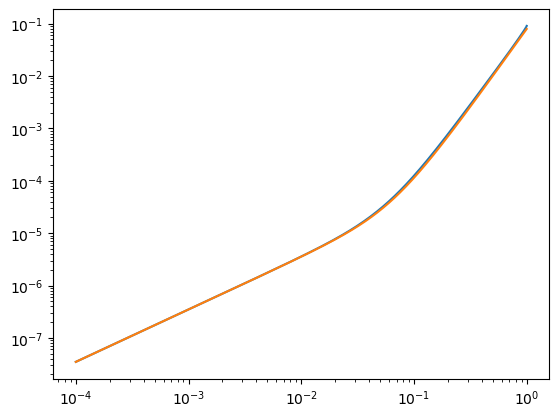

In [4]:
v4=4.2
v3= -22.6/(6*np.sqrt(2))

mu_g=440
a0=0
zh,q = blackness(T,mu)

zeta=np.sqrt(3)/(2*np.pi)

ui=1e-4
uf=1-ui
u=np.linspace(ui,uf,1000)
params=v3,v4,lambda1,mu_g,a0,zh,q

sl=105.3

s2=-3*(ml*zeta)**2*v3
s3=-9*(zeta*ml)**3*v3**2 + 2*(zeta*ml)**3*v4 + ml*zeta*mu_g**2 - 1/2*ml*zeta*lambda1*mu_g**2

#use this line if deltasig is an integer
# for sl in range (minsigma,maxsigma,deltasig):

#use these next two lines if deltasig is not an integer

"values for chiral field and derivative at UV boundary"
sigmal = sl**3
UVbound = [ml*zeta*zh*ui + sigmal/zeta*(zh*ui)**3+s2*(zh*ui)**2+s3*(zh*ui)**3*np.log(zh*ui), 
            ml*zeta*zh + 3*sigmal/zeta*zh**3*ui**2 + 2*s2*zh**2*ui + s3* ui**2*zh**3*(1+3*np.log(zh*ui))]
    
"solve for the chiral field"
chiFields=odeint(chiral,UVbound,u,args=(params,))

chi=chiFields[:,0]
chiPrime=chiFields[:,1]
print("d0 is", chi[-1])
plt.loglog(u,chi)
plt.loglog(u, ml*zeta*zh*u+sigmal/zeta*(zh*u)**3)
plt.show()


# Solving from IR first, using that value of $\sigma$

cube root of sigma is 299.13599698085744


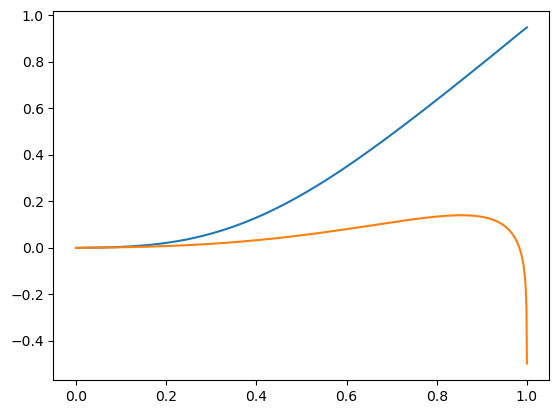

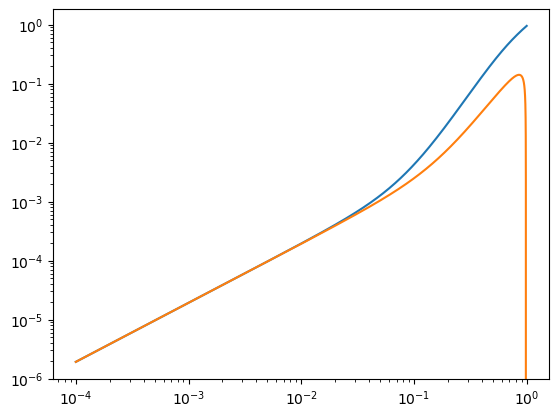

In [41]:
T=110
mu=0
ml=24
d0=0.9482352873419942
lambda1=7
zeta=np.sqrt(3)/(2*np.pi)
ui=1e-4
uf=1-ui

# solve for chi using chiral_solve_IR
mq,chi_IR,chip_IR,u=chiral_solve_IR(d0,lambda1,T,mu,ui,uf)

#solve for sigma using sigma_finder
u_intermediate=0.05
sigma=sigma_finder(u_intermediate,chi_IR,u,mq,T,mu,zeta,v3)

print("cube root of sigma is", sigma**(1/3))

#solve for chi using chiral_solve_UV
sigma=270**3

chi_UV,chip_UV,u=chiral_solve_UV(ml,sigma,T,mu,ui,uf,lambda1)

#plot
plt.plot(u,chi_IR)
plt.plot(u,chi_UV)
plt.show()

plt.loglog(u,chi_IR)
plt.loglog(u,chi_UV)
plt.show()



# Solving for sigma using UV solution first

sigma list is [287. 290. 293.]


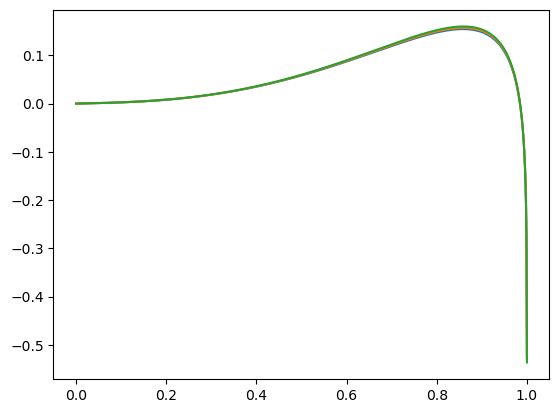

In [112]:
minsigma=0
maxsigma=300
T=110
args=(T,mu,ml,minsigma,maxsigma,a0,lambda1)
sigma_list=allSigmas(args)
print("sigma list is", sigma_list)

# loop over all values of sigma, solving for chi and chi prime using chiral_solve_UV 

chi_list=[]
chip_list=[]
for sigma in sigma_list:
    if sigma != 0:
        sl=(sigma)**3
        chi,chip,u=chiral_solve_UV(ml,sl,T,mu,ui,uf,lambda1)
        chi_list.append(chi)
        chip_list.append(chip)


#plot
for i in range(len(chi_list)):
    plt.plot(u,chi_list[i])
plt.show()


In [109]:
#create an array of u_intermediate values
u_intermediate_list=np.logspace(-4,-1,40)

#loop over all values of u_intermediate, solving for sigma and chi using sigma_finder 

sigma_list=[]
chi_list=[]
for u_intermediate in u_intermediate_list:
    sigma=sigma_finder(u_intermediate,chi_IR,u,mq,T,mu,zeta,v3)
    sigma_list.append(sigma)
    chi,chip,u=chiral_solve_UV(ml,sigma,T,mu,ui,uf,lambda1)
    chi_list.append(chi)

#plot
# for i in range(len(chi_list)):
#     plt.plot(u,chi_list[i])
# plt.plot(u,chi_IR,'k')
# plt.show()



/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_76682/2286042477.py:3: RuntimeWarning: invalid value encountered in power
  plt.scatter(np.log10(u_intermediate_vals),np.real(sigma_vals**(1/3)))


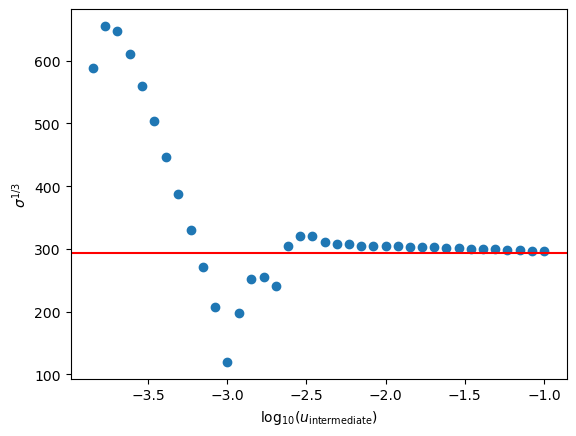

In [110]:
sigma_vals=np.array(sigma_list)
u_intermediate_vals=np.array(u_intermediate_list)
plt.scatter(np.log10(u_intermediate_vals),np.real(sigma_vals**(1/3)))
plt.xlabel("$\log_{10} (u_\mathrm{intermediate})$")
plt.ylabel("$\sigma^{1/3}$")
#draw a line at the value of sigma that we want         
plt.axhline(y=sl**(1/3), color='r', linestyle='-')
plt.show()


# Comparing $\sigma$ values from the two methods
## Solving from the UV

In [99]:
from criticalZoom import order_checker
# create an array of temperature values from 80 to 130 with a step size of 1
minsigma=0
maxsigma=300
tmin=60
tmax=85
numtemp=31
mu=0
lambda1=7
a0=0
mu=600
ml=24

tmin,tmax,minsigma,maxsigma,order,temps1,truesigma,Tc=order_checker(tmin,tmax,numtemp,minsigma,maxsigma,ml,mu,lambda1,a0)



get_all_sigmas_parallel took 4.078sec
First order
Critical temperature is  73.33333333333333


## Solving from IR to get $\sigma$

In [104]:
def find_d0_hard_way(T,mu,mq_target,d0_lower,d0_upper):
    buffer=1
    d0_array=np.linspace(d0_lower,d0_upper,1000)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)

    iterations=0
    step_size=d0_array[1]-d0_array[0]

    while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/10
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
        indices=np.where(np.abs(mq_array)>1000)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1

    #find the index of the value of mq that is closest to mq_target
    index=np.argmin(np.abs(mq_array-mq_target))
    upper_index=min(index+buffer,len(d0_array)-1)
    lower_index=max(index-buffer,0)
    d0_lower=d0_array[lower_index]
    mq_lower=mq_array[lower_index]
    d0_upper=d0_array[upper_index]
    mq_upper=mq_array[upper_index]
    #if the target value is not in the range, increase the buffer and try again
    while mq_target>max(mq_upper,mq_lower) and buffer<len(d0_array):
        buffer=buffer+1
        lower_index=max(index-buffer,0)
        upper_index=min(index+buffer,len(d0_array)-1)
        d0_lower=d0_array[lower_index]
        mq_lower=mq_array[lower_index]
        d0_upper=d0_array[upper_index]
        mq_upper=mq_array[upper_index]
    while mq_target<min(mq_upper,mq_lower) and buffer<len(d0_array):
        buffer=buffer+1
        lower_index=max(index-buffer,0)
        upper_index=min(index+buffer,len(d0_array)-1)
        d0_lower=d0_array[lower_index]
        mq_lower=mq_array[lower_index]
        d0_upper=d0_array[upper_index]
        mq_upper=mq_array[upper_index]
    mq_approx=(mq_lower+mq_upper)/2
    return d0_lower,d0_upper,mq_approx,mq_lower,mq_upper


In [97]:
temps=np.linspace(120,150,31)
#create an array of length temps to store the values of sigma
sigma_IR_list=np.zeros(len(temps))
d0_list=np.zeros(len(temps))
chi_list=[]
mq_list=np.zeros(len(temps))
ui=1e-4
uf=1-ui
zeta=np.sqrt(3)/(2*np.pi)

#loop over temps
for i in range(len(temps)):
    T=temps[i]
    mq_input=24
    d0_lower=0
    d0_upper=15
    mq_approx=0
    iterations=0
    while np.abs(mq_approx-mq_input)>1e-3 and iterations<15:
        d0_lower,d0_upper,mq_approx,mq_lower,mq_upper=find_d0_hard_way(T,mu,mq_input,d0_lower,d0_upper)
        iterations+=1

    d0_list[i]=(d0_lower+d0_upper)/2
    #solve for chi and chi prime using chiral_solve_IR
    mq,chi_IR,chip_IR,u=chiral_solve_IR(d0_list[i],lambda1,T,mu,ui,uf)
    mq_list[i]=mq
    chi_list.append(chi_IR)
    #solve for sigma using sigma_finder
    u_intermediate=0.15
    sigma=sigma_finder(u_intermediate,chi_IR,u,mq_input,T,mu,zeta,v3)
    #store sigma in sigma_IR_list
    sigma_IR_list[i]=sigma
    if iterations==15:
        print("failed to converge for T=",T, "with mq=",mq_approx, "and cube root sigma=",sigma**(1/3))

sigmas_IR=np.array(sigma_IR_list)
    

In [110]:
temps=np.linspace(10,85,30)
#create an array of length temps to store the values of sigma
sigma_IR_list=np.zeros(len(temps))
d0_list=np.zeros(len(temps))
chi_list=[]
mq_list=np.zeros(len(temps))
ui=1e-4
uf=1-ui
mu=600
zeta=np.sqrt(3)/(2*np.pi)

#loop over temps
for i in range(len(temps)):
    T=temps[i]
    mq_input=24
    d0_lower=0
    d0_upper=15
    mq_approx=0
    iterations=0
    while np.abs(mq_approx-mq_input)>1e-3 and iterations<15:
        d0_lower,d0_upper,mq_approx,mq_lower,mq_upper=find_d0_hard_way(T,mu,mq_input,d0_lower,d0_upper)
        iterations+=1

    d0_list[i]=(d0_lower+d0_upper)/2


    if iterations==15:
        print("failed to converge for T=",T, "with mq=",mq_approx)
        #remove the  value of d0_list at index i and the corresponding value of temps
        sigma_IR_list=np.delete(sigma_IR_list,i)
        temps=np.delete(temps,i)
        d0_list=np.delete(d0_list,i)
    
#create an interpolating function for d0_list vs temps
d0_interp=interp1d(temps,d0_list)






In [111]:
for i in range(len(temps)):
    T=temps[i]
    #solve for chi and chi prime using chiral_solve_IR
    #find d0 using d0_interp (not a good idea when there's a first-order transiton)
    #d0=d0_interp(T)
    mq,chi_IR,chip_IR,u=chiral_solve_IR(d0_list[i],lambda1,T,mu,ui,uf)
    mq_list[i]=mq
    chi_list.append(chi_IR)
    #solve for sigma using sigma_finder
    u_intermediate=0.15
    sigma=sigma_finder(u_intermediate,chi_IR,u,mq_input,T,mu,zeta,v3)
    #store sigma in sigma_IR_list
    sigma_IR_list[i]=sigma


sigmas_IR=np.array(sigma_IR_list)

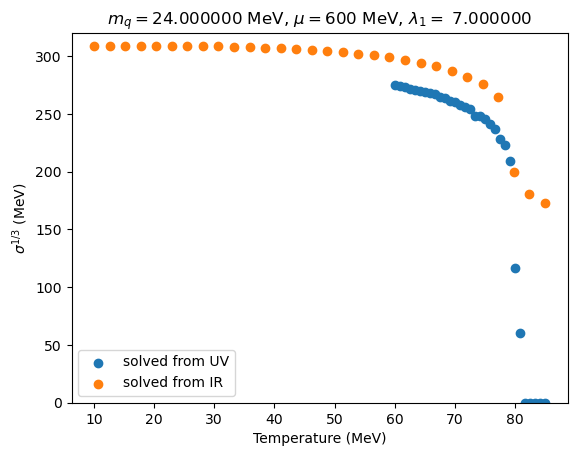

In [112]:
plt.scatter(temps1,truesigma[:,0],label="solved from UV")
# plt.scatter(temps1,truesigma[:,1],label="solved from UV")
# plt.scatter(temps,truesigma[:,2],label="solved from UV")
plt.scatter(temps,sigmas_IR**(1/3),label="solved from IR")
# plt.scatter(temps_old,sigmas_old**(1/3),label="solved from IR")
plt.xlabel("Temperature (MeV)")
plt.ylabel("$\sigma^{1/3}$ (MeV)")
plt.legend()
plt.ylim(0,320)
#set the x range
#plt.xlim(temps_list[0][0],max_temp)
#plt.ylim([np.amin((1.05*sigma_list[0]/1000))**3,np.amax((1.05*sigma_list[0]/1000))**3])
plt.title(r'$m_q=%f$ MeV, $\mu=%i$ MeV, $\lambda_1=$ %f' %(ml,mu,lambda1))
plt.show()

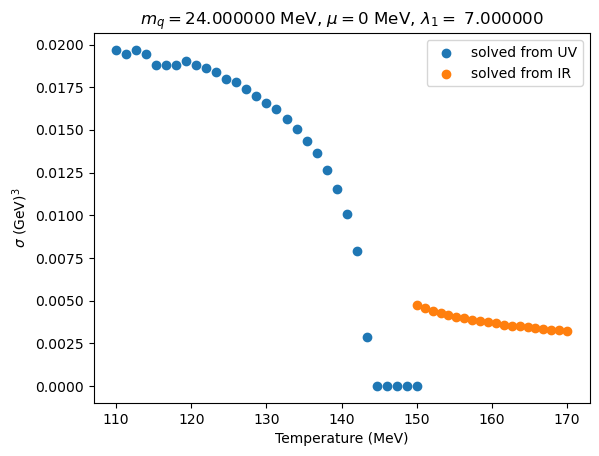

In [91]:
plt.scatter(temps1,(truesigma[:,0]/1000)**3,label="solved from UV")
# plt.scatter(temps,truesigma[:,1],label="solved from UV")
# plt.scatter(temps,truesigma[:,2],label="solved from UV")
plt.scatter(temps,sigmas_IR/1000**3,label="solved from IR")
plt.xlabel("Temperature (MeV)")
plt.ylabel("$\sigma$ (GeV)$^3$")
plt.legend()
#set the x range
#plt.xlim(temps_list[0][0],max_temp)
#plt.ylim([np.amin((1.05*sigma_list[0]/1000))**3,np.amax((1.05*sigma_list[0]/1000))**3])
plt.title(r'$m_q=%f$ MeV, $\mu=%i$ MeV, $\lambda_1=$ %f' %(ml,mu,lambda1))
plt.show()

In [82]:
sigmas_old=sigmas_IR

In [83]:
temps_old=temps

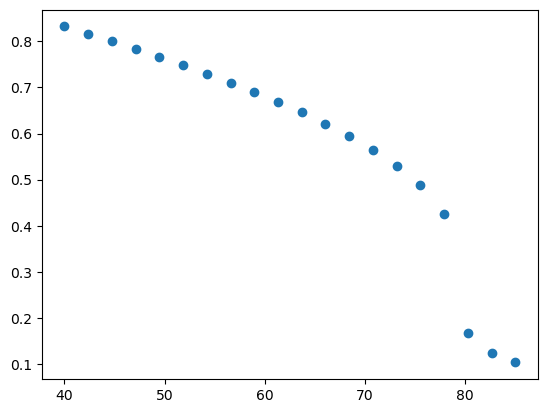

In [109]:
plt.scatter(temps,d0_list)
plt.show()

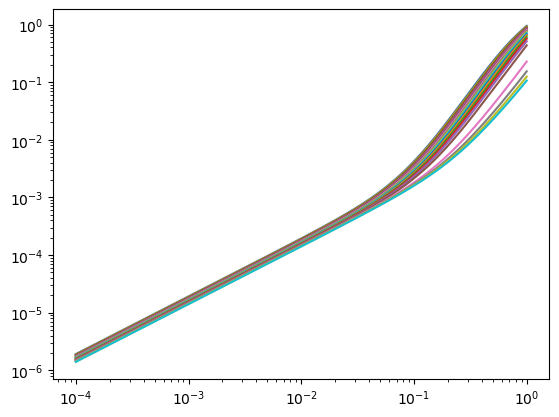

In [226]:
# plot all elements of chi_list
for i in range(len(chi_list)):
    plt.loglog(u,chi_list[i])
plt.show()


In [176]:
mq_input

24

In [30]:
T=40
mq_input=24
d0_lower=0
d0_upper=5
mq_approx=0
iterations=0
while np.abs(mq_approx-mq_input)>1e-3 and iterations<15:
    d0_lower,d0_upper,mq_approx,mq_lower,mq_upper=find_d0_hard_way(T,mq_input,d0_lower,d0_upper)
    iterations+=1
    print("quark mass is between %f and %f" %(mq_lower,mq_upper))
    print("d0 is between %f and %f" %(d0_lower,d0_upper))
d0_best=(d0_lower+d0_upper)/2
print(d0_best)
mq,chi_IR,chip_IR,u=chiral_solve_IR(d0_best,lambda1,T,mu,ui,uf)
#solve for sigma using sigma_finder
u_intermediate=0.01
sigma=sigma_finder(u_intermediate,chi_IR,u,mq_input,T,mu,zeta,v3)
print(sigma**(1/3))
print(mq_approx)

100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between 0.000000 and 5.000000
100
quark mass is between -0.000000 and -77699699.432926
d0 is between

ValueError: x and y arrays must be equal in length along interpolation axis.

In [56]:
mq_lower,chi_IR,chip_IR,u=chiral_solve_IR(d0_lower,lambda1,T,mu,ui,uf)
mq_upper,chi_IR,chip_IR,u=chiral_solve_IR(d0_upper,lambda1,T,mu,ui,uf)
print(mq_lower,mq_upper)

24.017947909964278 23.966355015798957


In [70]:
d0_lower-d0_upper

-2.7755575615628914e-17